In [1]:
## loading python libraries

# necessary to display plots inline:
%matplotlib inline   

# load the libraries
import matplotlib.pyplot as plt # 2D plotting library
import numpy as np              # package for scientific computing  

from math import *              # package for mathematics (pi, arctan, sqrt, factorial ...)

In [2]:
## XXXXXXX INPUT / OUTPUT XXXXXXXXXX
def eval_Horner(a,x,X):
    N = a.size
    R = a[-1]
    for k in range(1,N):
        R = R * (X - x[-k])
        R = R + a[-1-k]
    return R

In [3]:
## XXXXXXX INPUT / OUTPUT XXXXXXXXXX
def divided_diff(x, y):
    n = x.size
    deltak = y.copy() # Use copy to prevent the values in y from being modified 
    for k in range(1,n):
        deltak[k:] = (deltak[k:] - deltak[k-1:-1])/(x[k:] - x[:-k])
    return deltak

In [4]:
## XXXXXXX INPUT / OUTPUT XXXXXXXXXX
## XXXXXXX RETIRER DELTA DE OUTPUT SI ON L'UTILISE PAS DS LA SUITE XXXXXXXXXX
def LagrangeInterp(x, y, X):
    delta = divided_diff(x, y)
    R = eval_Horner(delta, x[:-1], X)
    return (R, delta)

# Polynomial interpolation for missing data

We use interpolation to 
- Determine the population in 1945 (j'ai choisi cette année pour qu'il y ait une différence entre le modèle linéaire et l'interpolation de Lagrange)
- Determine the approximate time at which the number of living humans went past the $2.2$ Billions mark. 

We use the following data (source http://www.worldometers.info/world-population/world-population-by-year/)

| Year | Pop. | Year | Pop. |
| --- | --- |
| 1900 | 1,600,000,000 | 1985 | 4,873,781,796 |
| 1927 | 2,000,000,000 | 1990 | 5,330,943,460 |
| 1951 | 2,583,816,786 | 1995 | 5,751,475,416 |
| 1955 | 2,772,242,535 | 2000 | 6,145,006,989 |
| 1960 | 3,033,212,527 | 2005 | 6,542,159,383 |
| 1965 | 3,339,592,688 | 2010 | 6,958,169,159 |
| 1970 | 3,700,577,650 | 2015 | 7,383,008,820 |
| 1975 | 4,079,087,198 | 2018 | 7,632,819,325 |
| 1980 | 4,458,411,524 | 



We can store this in a numpy array and plot the evolution of population. 

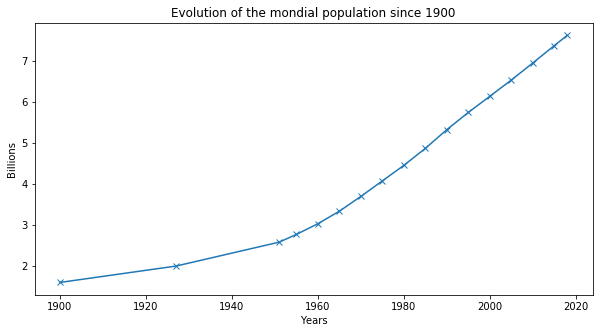

In [5]:
yearsData = np.array([1900,1927,1951,1955,1960,1965,1970,1975,1980,1985,1990,1995,2000,2005,2010,2015,2018])
popData = np.array([1.6,2,2.583816786,2.772242535,3.033212527, 3.339592688,3.700577650,4.079087198,4.458411524,
                4.873781796,5.330943460,5.751475416,6.145006989,6.542159383,6.958169159,7.383008820,7.632819325])

plt.figure(figsize=(10,5))
plt.plot(yearsData,popData,marker="x")
plt.title('Evolution of the mondial population since 1900')
plt.xlabel('Years')
plt.ylabel('Billions')
plt.show()

<div markdown = 1, class = "Rmk"> In the previous plot, the line corresponds to the P1 interpolation of the data, since python draws straight line between each data point.  

## 1°) Using P1 piecewise polynomial

If we approximate the curve by the piecewise affine interpolate, then 
- The approximate population $p$ at year $y = 1945$ is given by the formula

$$ p = p_1 + \frac{y - y_1}{y_2 - y_1}(p_2-p_1) $$

 where $(y_1,p_1)$ and $(y_2,p_2)$ are two consecutive data points, where the varaibles $p_i$ represent the   population, where $y_i$ represents the year and such that $y_1 < y$ and $y_2 > y$. 

- the time $y$ at which the population went above $p = 2.2$ billions can be expressed as 

$$y = y_1 + \frac{p - p_1}{p_2 - p_1}(y_2 - y_1)$$



where $(y_1,p_1)$ and $(y_2,p_2)$ are two consecutive data points, where the varaibles $p_i$ represent the population, with $p_1 < 7$ and $p_2 > 7$ and where $y_i$ represents the year. 

In [6]:
## Population in 1945

yTarget1 = 1945

idx = np.argmin(abs(yearsData - yTarget1))
if yearsData[idx]<yTarget1:
    jdx = idx + 1
else:
    jdx = idx-1
left = min(idx,jdx)
right = max(idx,jdx)
pi = popData[left]; pj = popData[right]; yi = yearsData[left]; yj = yearsData[right]

pTarget1 = pi + (yTarget1 - yi)/(yj - yi)*(pj - pi)
print('According to piecewise affine model, there were',pTarget1,'billions of human beings in',yTarget1)


## 2.2 Billions mark

pTarget2 = 2.2

idx = np.argmin(abs(popData - pTarget2))
if popData[idx]<pTarget2:
    jdx = idx + 1
else:
    jdx = idx-1
left = min(idx,jdx)
right = max(idx,jdx)


pi = popData[left]; pj = popData[right]; yi = yearsData[left]; yj = yearsData[right]
yTarget2 = yi + (pTarget2-pi)/(pj - pi)*(yj - yi) 
m = (yTarget2 - int(yTarget2))*12
months = ['jan.','feb.','mar.','apr.','may','june','jul.','aug.','sep.','oct.','nov.','dec.']
print('According to piecewise affine model, the population went above',pTarget2,'billions in',months[int(m)-1],'of',int(yTarget2))

ResultsP1 = (pTarget1,yTarget1,pTarget2,yTarget2)

According to piecewise affine model, there were 2.4378625895 billions of human beings in 1945
According to piecewise affine model, the population went above 2.2 billions in feb. of 1935


## Using Lagrange interpolation

We now wish to approximate the population curve by a smoother curve than just piecewise affine. For that, we are going to use the Lagrange interpolation at the data points. 

The next example shows that if we take all the data points, the interpolation yields very bad results:

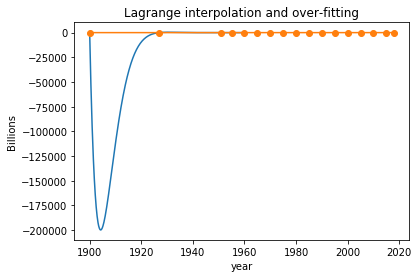

In [7]:
# We retrieve the coefficients of the Lagrange interpolation polynomial 
# using the divided differences method.
yearsPlot = np.linspace(1900,1960,500)
x = yearsData
y = popData
(R,delta) = LagrangeInterp(x, y, yearsPlot)

# We plot the interpolated curve
plt.plot(yearsPlot,R)
plt.plot(x,y,marker = 'o')
plt.title('Lagrange interpolation and over-fitting')
plt.xlabel('year')
plt.ylabel('Billions')
plt.show()


This kind of situation is analog to "overfitting" in machine learning and statistics. Overfitting often arises when one uses a model with too many parameters to fit a data set. This leads to great accuracy at the training (known) data and bad accuracy at the test (unknown) data. It is generally thought that a model that has less parameters will have better generalization capacities. So here, a possible idea is to restrict the number of data points and choose them around the zone we are interested in. This will lead to an approximation by a polynomial of lower-order, smaller coefficients. 

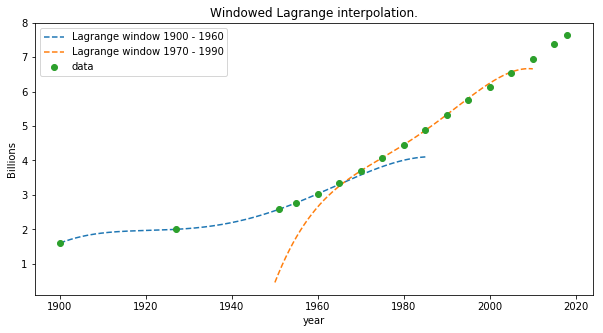

In [8]:
def windowedLagrangeInterp(data_x,data_y,x_interest,nLeft,nRight,x_eval):
    id_x = np.argmin(abs(data_x - x_interest))
    id_xs = np.arange(id_x - nLeft,id_x + nRight + 1)
    id_xs = id_xs[np.logical_and(id_xs >= 0,id_xs <data_x.size)]
    x = data_x[id_xs] # We select the data near the year of interest
    y = data_y[id_xs]
    (R,delta) = LagrangeInterp(x, y, x_eval)
    return (R,delta,x,y)


xPlot1 = np.linspace(1900,1985,500)
xPlot2 = np.linspace(1950,2010,500)
nLeft = 2
nRight = 2
(R1,delta,x_interp1,yinterp1) = windowedLagrangeInterp(yearsData,popData,1945, 2, 2,xPlot1)
(R2,delta,x_interp2,yinterp2) = windowedLagrangeInterp(yearsData,popData,1980, 2, 2,xPlot2)
# We plot the result 
figure = plt.figure(figsize = (10,5))
plt.plot(xPlot1,R1,label = 'Lagrange window ' + str(x_interp1[0]) + ' - ' + str(x_interp1[-1]) ,linestyle = '--')
plt.plot(xPlot2,R2,label = 'Lagrange window ' + str(x_interp2[0]) + ' - ' + str(x_interp2[-1]),linestyle = '--')
plt.plot(yearsData,popData,label = 'data',marker = 'o',linestyle='')
plt.title('Windowed Lagrange interpolation.')
plt.xlabel('year')
plt.ylabel('Billions')
plt.legend()
plt.show()


We will use this technique to approximate locally the population curve near the zone that concerns us, namely near the years 1930 - 1950. To evaluate the population in 1945, we just have to evaluate the interpolation polynomial at $x = 1945$. To determine the year at which the population was equal to $2.2$ billions, we can use the rootfinding methods developped in the previous practical session, that is find the zero of $P(x) - 2.2$ where $P$ is the interpolation polynomial. 

In [9]:
## Bisection algorithm for function f
## input : f = name of the function
##         a0, b0 = initial intervall I_0 with f(a0)f(b0)<0
##         eps  = tolerance
##         Kmax = maximal number of iterations allowed
## output : x = sequence approximating the zero of f

def Bisection(f,a0,b0,eps,Kmax):
    # create vector x
    x = np.zeros(Kmax+1)
    k = 0
    a = a0
    b = b0
    x[0] = (a+b)/2  # sets x_0 = (a+b)/2
    # computation of x_k
    while (b0-a0)/(2**k) >= eps and k < Kmax:
        if f(a)*f(x[k]) < 0:
            b = x[k]
        else:
            a = x[k]
        k = k+1
        x[k] = (a+b)/2
    return (x, k)

According to Lagrange method, there were 2.36230818627 billions of human beings in 1945
According to Lagrange method, the population went above 2.2 billions in dec. of 1938


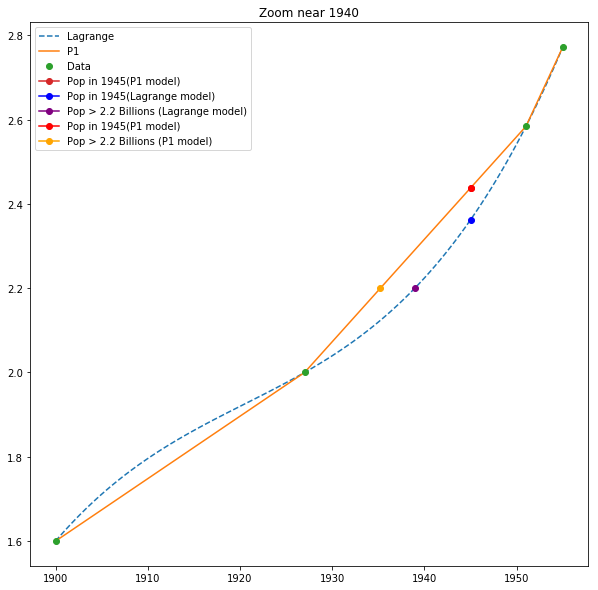

In [10]:
approxYear = 1940
# Let's zoom in the region of interest : 

(R,delta,x_interp,y_interp) = windowedLagrangeInterp(yearsData,popData,approxYear,2, 1,1)

# The interpolation polynomial can now be defined and displayed: 
def interp(x):
    return eval_Horner(delta,x_interp[:-1],x)

# Population in 1945: 
yTarget1 = 1945
pTarget1 = interp(yTarget1)

print('According to Lagrange method, there were',pTarget1,'billions of human beings in',yTarget1)


# 2.2 billions mark: 
pTarget2 = 2.2


def funcRootFind(x):
    return (interp(x) - pTarget2)


a0 = 1930
b0 = 1960
eps = 1e-10
Kmax = 50

(x,k) = Bisection(funcRootFind,a0,b0,eps,Kmax)
y = int(x[k])
m = months[int((x[k]-y)*12)]
yTarget2 = x[k]
print('According to Lagrange method, the population went above',pTarget2,'billions in',m,'of',int(yTarget2))


#Plot and compare the two methods

(p1P1,y1P1,p2P1,y2P1) = ResultsP1
xPlot = np.linspace(x_interp[0],x_interp[-1],100)

fig = plt.figure(figsize = (10,10))
plt.plot(xPlot,interp(xPlot),linestyle = '--',label = 'Lagrange')
plt.plot(yearsData[:4],popData[:4],label = 'P1')
plt.plot(yearsData[:4],popData[:4],linestyle = '', marker = 'o', label = 'Data')
plt.plot(y1P1,p1P1,marker = 'o',label = 'Pop in ' + str(y1P1) + '(P1 model)')
plt.plot(yTarget1,pTarget1,marker = 'o',label = 'Pop in ' + str(y1P1) + '(Lagrange model)',color = 'blue')
plt.plot(yTarget2,pTarget2,marker = 'o',label = 'Pop > ' + str(p2P1) + ' Billions (Lagrange model)',color = 'purple')
plt.plot(y1P1,p1P1,marker = 'o',label = 'Pop in ' + str(y1P1) + '(P1 model)',color = 'red')
plt.plot(y2P1,p2P1,marker = 'o',label = 'Pop > ' + str(p2P1) + ' Billions (P1 model)',color = 'orange')
plt.legend()
plt.title('Zoom near ' + str(approxYear))
plt.show()

In [11]:
# execute this part to modify the css style
from IPython.core.display import HTML
def css_styling():
    styles = open("./style/custom2.css").read()
    return HTML(styles)
css_styling()